In [102]:
import numpy as np, pandas as pd, numpy.random as random
from matplotlib import pyplot as plt
from scipy.optimize import minimize
import scipy.stats as stats
from tqdm import tqdm
from matplotlib.ticker import FuncFormatter
import scipy.optimize as op
import os
from nltk import flatten
import matplotlib
matplotlib.rc_file_defaults()

Using the estimates found by maximum likelihood estimation, we now simulate data for each model.

We first define the condtional intensity function of SE (single station) model:

In [39]:
def cond_int_fun(t, times, param):
    """
    Find the value of the conditional intensity function at time t using given parameters.
    """
    
    beta, theta, lambda_b = param[0], param[1], param[2]
    lambda_t = lambda_b 
    times0 = times.copy()
    
    ind = np.searchsorted(times, t, side='right')
    if ind > 0:
        times0 = times0[0:ind]
        lambda_t += np.sum(beta * np.exp(-theta*(t-times0)))
        
    return lambda_t

And produce a plot.

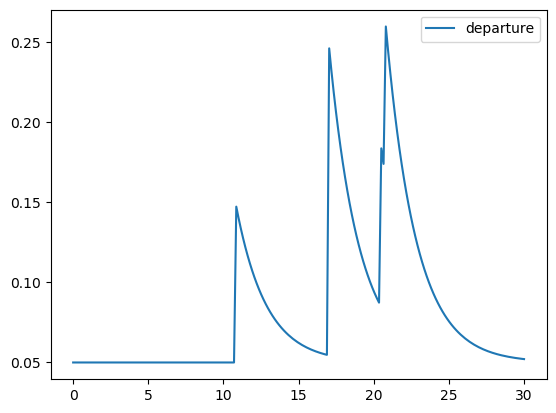

In [110]:
times = np.sort(random.uniform(0,30,size=5))
t = np.linspace(0, 30, 200)
para = [0.1, 0.5, 0.05]
lamb = []

for i in range(len(t)):
    lamb.append(cond_int_fun(t[i], times, para))

plt.plot(t, lamb, label='departure')
plt.legend()
plt.savefig('sim se.pdf')
plt.show()

We implement the function to simulate from Hawkes process.

In [50]:
def hawkes_sim(n, param):
    """
    Simulate n event time data using given parameters.
    """
    
    beta, theta, lambda_b = param[0], param[1], param[2]
    
    times = []
    t0 = random.exponential(1/lambda_b, 1)[0]
    times.append(t0)
    lambda_t = cond_int_fun(t0, times, param)
    
    while len(times) < n:
        t1 = t0 + random.exponential(1/lambda_t, 1)[0]
        lambda_t1 = cond_int_fun(t1, times, param)
        
        u = random.uniform(low = 0.0, high = lambda_t, size = 1)
        if u <= lambda_t1:
            times.append(t1)
            #lambda_t += beta ## cond_int_fun(t1, times, param)
            lambda_t = lambda_t1 + beta
        else:
            lambda_t = lambda_t1
        t0 = t1
    
    return times

We simulate from some parameters, and plot the conditional intensity function.

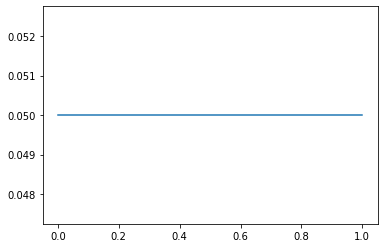

[4.068715249463902,
 6.433284425662872,
 32.89960765866565,
 35.73207294391798,
 38.510056657244476]

In [51]:
para = [0.1, 0.25, 0.05]
times = hawkes_sim(5, para)
t = np.linspace(0, 1.0, 200)
lamb = []

for i in range(len(t)):
    lamb.append(cond_int_fun(t[i], times, para))

plt.plot(t, lamb);
plt.show();
times

We simulate using parameter values obtained from maximum likelihood estimation.

[0.01763067 0.01788917 0.00011184]


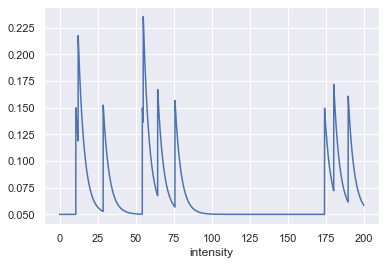

In [99]:
para_res = np.array([-4.03811537, -8.26060587, -9.09840813])
param = np.array([np.exp(para_res[0]), np.exp(para_res[0])+np.exp(para_res[1]), np.exp(para_res[2])])
print(param)

param = np.array([0.1, 0.25, 0.05])

times = hawkes_sim(10, param)

t = np.linspace(np.floor(times[0]/100)*100, np.ceil(times[-1]/100)*100, 5000)
lamb = []

for i in range(len(t)):
    lamb.append(cond_int_fun(t[i], times, param))


plt.plot(t, lamb)
plt.xlabel('t')
plt.xlabel('intensity')
plt.savefig("figure.png")

plt.show();
print()


Now we take this parameter to simulate data and perform maximum likelihood estimation again.

In [7]:
def hawkes_log_likelihood(t, beta, theta, lambda_b): 
    ratio = beta/theta
    A = np.zeros(len(t))
    T = t[-1]
    
    for i in range(1, len(t)):
        A[i] = np.exp(-theta*(t[i] - t[i-1]))*(1+A[i-1])
    
    first_sum = np.sum(np.log(lambda_b + beta*A))
    second_sum = ratio * np.sum(np.exp(-theta*(T - t)) - 1)
    res = first_sum + second_sum - lambda_b*T
    
    return res

In [8]:
t0 = hawkes_sim(5000, param)

In [9]:
op_hawkes_log_likelihood = lambda param, t: - hawkes_log_likelihood(t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), np.exp(param[2]))
mle = op.minimize(op_hawkes_log_likelihood, x0 = [np.log(param[0]), 0, np.log(param[2])], method = 'Nelder-Mead', args=(t0,))
mle.x

array([-2.3581185 , -1.94123952, -3.00287519])

In [10]:
np.exp(mle.x)

array([0.09459804, 0.14352594, 0.04964413])

We do simulations of size 1000 for 10 times, record the result from maximum likelihood estimation each time, and construct the histogram of the mle parameters.

In [33]:
n = 200
para_arr = np.zeros((n, 3))

for i in range(n):
    print('Iteration: ', i+1, '/',n, end='\r')
    t0 = hawkes_sim(1000, param)
    mle = op.minimize(op_hawkes_log_likelihood, x0 = [np.log(0.1), np.log(0.25-0.1), np.log(0.05)], method = 'Nelder-Mead', args=(t0,))
    para_arr[i, :] = mle.x
    
#para_arr

In [59]:
np.exp(mle.x)

array([0.09062033, 0.14112453, 0.04690117])

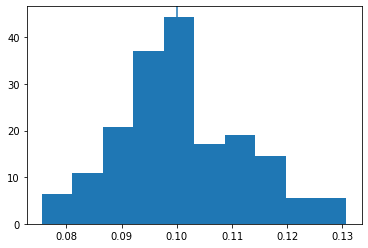

In [35]:
plt.hist(np.exp(para_arr[:n, 0]), density=True)
plt.axvline(x=0.1)
plt.show()

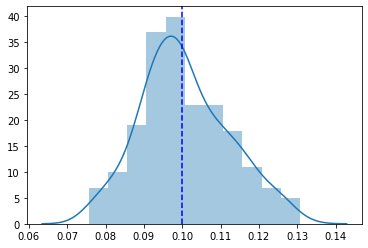

In [68]:
import seaborn as sns
plt = sns.distplot(np.exp(para_arr[:n, 0]), hist=True, kde=True)
plt.axvline(0.1, color = 'b', linestyle = '--')

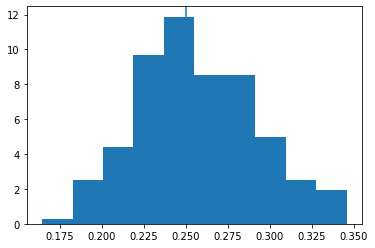

In [36]:
plt.hist(np.exp(para_arr[:n, 0])+ np.exp(para_arr[:n, 1]), density=True)
plt.axvline(x=0.25)
plt.show()

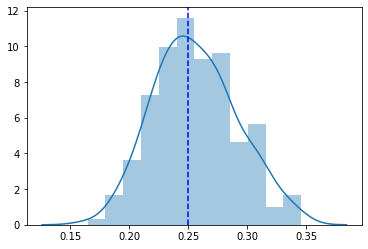

In [69]:
import seaborn as sns
plt = sns.distplot(np.exp(para_arr[:n, 0])+ np.exp(para_arr[:n, 1]), hist=True, kde=True)
plt.axvline(0.25, color = 'b', linestyle = '--')

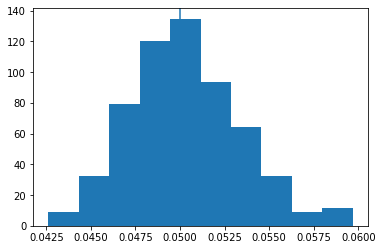

In [37]:
plt.hist(np.exp(para_arr[:n, 2]), density=True)
plt.axvline(x=0.05)
plt.show()

AttributeError: 'AxesSubplot' object has no attribute 'label'

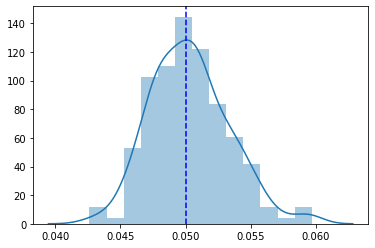

In [81]:
import seaborn as sns
plt = sns.distplot(np.exp(para_arr[:n, 2]), hist=True, kde=True)
plt.axvline(0.05, color = 'b', linestyle = '--')

We can combine the plots.

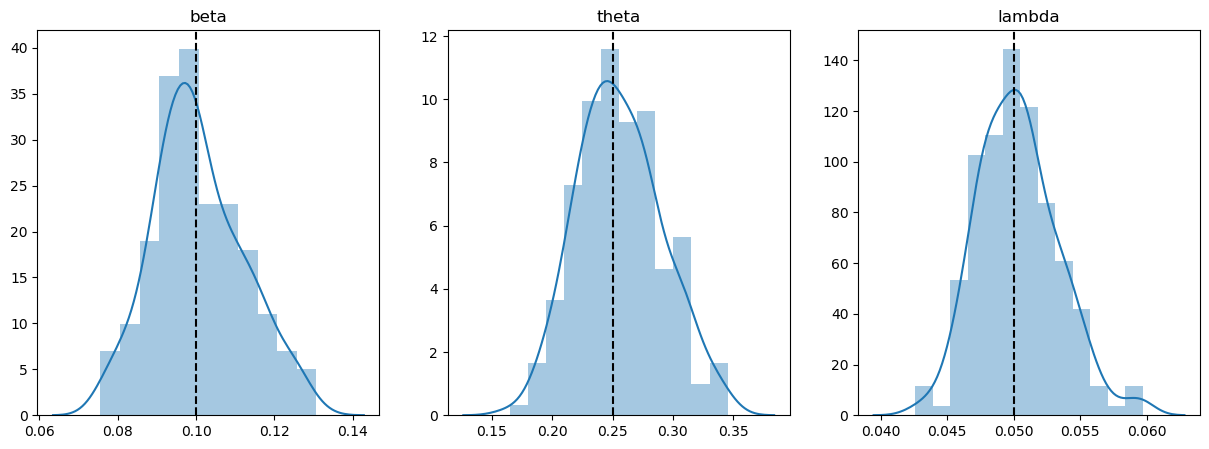

In [112]:
import seaborn as sns
from matplotlib import pyplot as plt
#sns.set()
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.distplot(np.exp(para_arr[:n, 0]), ax=axes[0], hist=True, kde=True)
axes[0].set_title('beta')
axes[0].axvline(0.1, color = 'black', linestyle = '--')

sns.distplot(np.exp(para_arr[:n, 0]) + np.exp(para_arr[:n, 1]), ax=axes[1], hist=True, kde=True)
axes[1].set_title('theta')
axes[1].axvline(0.25, color = 'black', linestyle = '--')

sns.distplot(np.exp(para_arr[:n, 2]), ax=axes[2], hist=True, kde=True)
axes[2].set_title('lambda')
axes[2].axvline(0.05, color = 'black', linestyle = '--')

plt.savefig('se sim.pdf')